In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

 Reflect Tables into SQLAlchemy ORM

In [4]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
 # Create our session (link) from Python to the DB
session = Session(engine)

Exploratory Climate Analysis

Last Date Measured:  2017-08-23
Query Date:  2016-08-23


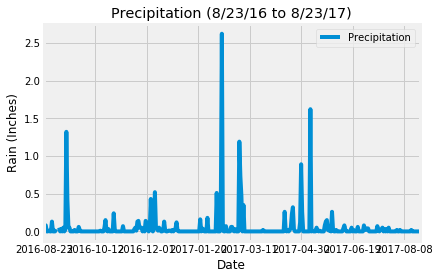

In [10]:
# Calculate the date 1 year ago from the last data point in the database
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date, = last
year,month,day = last_date.split('-')
query_date = dt.date(int(year),int(month),int(day)) - dt.timedelta(days=365)
print("Last Date Measured: ",last_date)
print("Query Date: ",query_date)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).group_by(Measurement.date).all()
rain

# Perform a query to retrieve the data and precipitation scores
rain_df = pd.DataFrame(rain)
rain_df.head()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_rain = rain_df.set_index("date")
df_rain.head()

# Sort the dataframe by date
df_rain.sort_values(["date"]).head()

# Use Pandas Plotting with Matplotlib to plot the data
df_rain.plot()
plt.xlabel("Date")
plt.ylabel("Rain (Inches)")
plt.title("Precipitation (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_rain.describe()

,prcp
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Measurement.station,
                                 func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())

# List the stations and the counts in descending order.
for row in station_activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
top_station = station_activity[0][0]
print(f"{top_station} is the most active station")

USC00519281 is the most active station


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
rec_top_station = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == top_station).all()

print(f"Station: {top_station}\n\
    Lowest temperature recorded:  {rec_top_station[0][0]}\n\
    Highest temperture recorded :  {rec_top_station[0][1]}\n\
    Average temperature recorded:  {rec_top_station[0][2]}")

Station: USC00519281
    Lowest temperature recorded:  54.0
    Highest temperture recorded :  71.66378066378067
    Average temperature recorded:  85.0


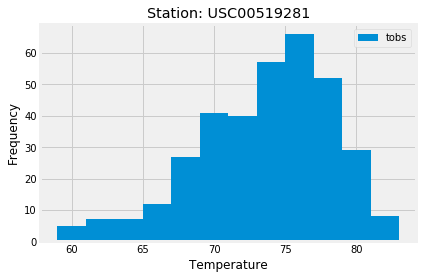

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == top_station).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()

temperature_df=pd.DataFrame(temperature)
plt.hist(temperature_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station: " + top_station)
plt.legend(["tobs"], loc="best")

plt.savefig("temp.png")
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
 # Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year = calc_temps('2011-02-28', '2011-03-05')
print(prev_year)

[(61.0, 69.75510204081633, 75.0)]


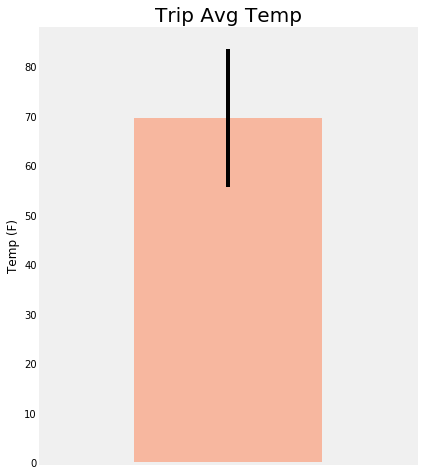

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr
prev_year_df = pd.DataFrame(prev_year, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = prev_year_df['Avg Temp']
min_max_temp = prev_year_df.iloc[0]['Max Temp'] - prev_year_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
RainfallPerStation = session.query(Measurement.station, Station.name, Station.latitude, 
                                   Station.longitude, Station.elevation, func.sum(Measurement.prcp))\
                                    .filter(Measurement.station == Station.station)\
                                    .filter(Measurement.date.between('2016-06-03','2016-06-09'))\
                                    .group_by(Measurement.station).all()
RainfallPerStation

[('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.7599999999999998),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.13999999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.54),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.4),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.02)]